In [2]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import eig, norm, det
from scipy.linalg import inv
from scipy.stats import multivariate_normal

%matplotlib notebook

## Funciones auxiliares

In [3]:
def ellipse(sigma, mean, scale=1):
    
    d, v = eig(inv(sigma))
    mat = v @ inv(np.sqrt(np.diag(d)))

    N = 200
    t = np.arange(0, N) * (2*np.pi) / N

    Y1 = scale * np.cos(t)
    Y2 = scale * np.sin(t)
   
    Y = np.array([Y1, Y2])

    X = mat.dot(Y)

    X1 = X[0]
    X2 = X[1]

    # move ellipse to mean_k
    X1 = X1 + mean[0]
    X2 = X2 + mean[1]
    
    return X1, X2

In [4]:
def plot(samples, parameters, classifier):
    
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    if classifier in ["lda", "k-means"]:

        sam_1 = samples["1"]
        sam_2 = samples["2"]
        sam_3 = samples["3"]

        data = (sam_1.T, sam_2.T, sam_3.T)
        colors = ("red", "green", "blue")
        groups = ("1", "2", "3")
        classes = (0,1,2)
        scales = (2, 2, 2)
        
        for data, color, group in zip(data, colors, groups):
            x, y = data
            ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

        for color, group, scale in zip(colors, classes, scales):
            X1, X2 = ellipse(parameters["sigmas"][group], parameters["means"][group], scale=scale)
            ax.plot(X1, X2, c=color)
            
        plt.legend(loc=2)

    else:
        
        data = samples.T
        gammas = parameters["gammas"]

        x = data[0]
        y = data[1]

        colors = [tuple(gammas[n]) for n in range(len(gammas))]
        scales = [2, 2, 2]

        ax.scatter(x, y, alpha=0.8, c=colors, edgecolors='none', s=30)

        for k in range(3):
            X1, X2 = ellipse(parameters["sigmas"][k], parameters["means"][k], scale=scales[k])
            ax.plot(X1, X2, c="black")
    
    plt.title('{} - 1,2,3'.format(classifier))
    plt.show()

In [5]:
def parse(d1, d2, d3, shuff=False, delim=35):

    # parse data
    with open(d1) as f:
        lines_a = list(csv.reader(f, delimiter='\t'))

    with open(d2) as f:
        lines_o = list(csv.reader(f, delimiter='\t'))

    with open(d3) as f:
        lines_u = list(csv.reader(f, delimiter='\t'))

    lines_a = list(map(lambda x: [int(x[0]), int(x[1])],lines_a))
    lines_o = list(map(lambda x: [int(x[0]), int(x[1])],lines_o))
    lines_u = list(map(lambda x: [int(x[0]), int(x[1])],lines_u))

    # make a 'shuffle' of the samples
    if shuff:
        np.random.shuffle(lines_a)
        np.random.shuffle(lines_o)
        np.random.shuffle(lines_u)
    
    # separate 'train' and 'test' datasets
    train_a = np.array(lines_a[:delim])
    test_a = np.array(lines_a[delim:])
    
    train_o = np.array(lines_o[:delim])
    test_o = np.array(lines_o[delim:])
    
    train_u = np.array(lines_u[:delim])
    test_u = np.array(lines_u[delim:])
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    data = {
        "train": {
            "1": train_a,
            "2": train_o,
            "3": train_u
        },
        "test": {
            "1": test_a,
            "2": test_o,
            "3": test_u
        }
    }
    
    return samples, data

In [6]:
def count_positive(test, g1, g2, g3, which):

    positive = 0

    for sample in test:
        
        predictions = [(g1(sample), "1"), (g2(sample), "2"), (g3(sample), "3")]
        prob, k = max(predictions, key=lambda x: x[0])
        
        if k == which:
            positive += 1

    return positive

In [34]:
def rotate(theta, x):
    
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    return rot @ x

## Algoritmos

### _LDA_

In [7]:
def lda(datasets):
    
    train = datasets["train"]
    
    # mean calc
    means = [np.mean(train["1"], axis=0),
             np.mean(train["2"], axis=0),
             np.mean(train["3"], axis=0)]
    
    # sigma calc
    sigmas = [np.cov(train["1"], rowvar=False),
              np.cov(train["2"], rowvar=False),
              np.cov(train["3"], rowvar=False)]

    return means, sigmas

### _K-Means_

In [8]:
def calc_dist(samples, classes, means):
    
    dist = 0.0
    
    for i in range(len(samples)):
        d = norm(samples[i] - means[int(classes[i])])
        dist += d
    
    return dist

In [9]:
def k_means(samples, means):
    
    it = 0
    classes = np.zeros(len(samples))
    dist = np.zeros(2)
    
    dist[0] = 0.0
    dist[1] = 1E6
    
    while abs(dist[1] - dist[0]) > 0.01:
    
        # calculate distance from every point
        # to the centroids (a.k.a means) and find a class for
        # each point
        for i in range(len(samples)):
            norms = [(norm(samples[i] - means[k]), k) for k in range(3)]
            n, k = min(norms, key=lambda x: x[0])
            classes[i] = k

        # calculate the new values for the
        # centroids (a.k.a means)
        for k in range(3):
            points_with_class_k = list(map(lambda y: y[0], filter(lambda x: x[1] == k, zip(samples, classes))))
            mean_k = np.mean(points_with_class_k, axis=0)
            means[k] = mean_k
        
        # calculate distorsion
        dist[0] = dist[1]
        dist[1] = calc_dist(samples, classes, means)
        it += 1

    return means, classes, it

In [10]:
def get_k_clusters(samples, classes, K=3):
    
    return [np.array(list(map(lambda y: y[0], filter(lambda x: x[1] == k, zip(samples, classes)))))
                    for k in range(K)]

In [11]:
def get_k_sigmas(clusters):
    
    return np.array([np.cov(c, rowvar=False) for c in clusters])

### _EM_

In [12]:
def calc_L(samples, means, sigmas, pi):
    
    x = samples
    
    return sum([np.log(sum([multivariate_normal.pdf(x[n], mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])) for n in range(len(samples))])

In [13]:
def calc_means(samples, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    m = np.array([sum([samples[n]*gammas[n][k] for n in range(len(samples))]) for k in range(3)])
    
    return np.array([m[i]/den[i] for i in range(len(m))])

In [14]:
def calc_sigmas(samples, means, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    sigmas = []
    sigmas_k = []
    
    for k in range(3):
        for n in range(len(samples)):
            res = np.array(list(map(lambda y: [y], samples[n]-means[k])))
            s = gammas[n][k] * res @ res.T
            sigmas_k.append(s)
        sigmas.append(sum(sigmas_k) / den[k])
        sigmas_k.clear()
    
    return sigmas

In [15]:
def calc_pi(gammas, N):

    num = calc_denom(gammas)
    
    return num / N

In [16]:
# calculates the sum of gammas
# for all the classses
# returns:
#   [sum(gammas[0]), sum(gammas[1]), sum(gammas[2])]
def calc_denom(gammas):

    N = len(gammas)
    
    d = np.array([sum([gammas[n][k] for n in range(N)]) for k in range(3)])
    
    return d

In [17]:
def gamma(sample, means, sigmas, pi):
    
    nums = np.array([multivariate_normal.pdf(sample, mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])

    den = nums.sum()
    
    return nums / den

In [18]:
def em(samples, means, sigmas, pi):

    it = 0
    L = np.zeros(2)
    L[0] = 0.0
    L[1] = calc_L(samples, means, sigmas, pi)
    deltaL = L[1] - L[0]
    
    while abs(deltaL) > 0.01:

        ############
        # 'E' step #
        ############
        gammas = np.array([gamma(samples[i], means, sigmas, pi) for i in range(len(samples))])

        ############
        # 'M' step #
        ############
        
        # calc new means
        means = calc_means(samples, gammas)

        # calc new sigmas
        sigmas = calc_sigmas(samples, means, gammas)

        # calc new pi
        pi = calc_pi(gammas, len(samples))

        L[0] = L[1]
        L[1] = calc_L(samples, means, sigmas, pi)
        deltaL = L[1] - L[0]
        it += 1

    return means, sigmas, gammas, pi, it

In [19]:
def get_em_sigmas(data):

    d1 = data["1"]
    d2 = data["2"]
    d3 = data["3"]
    
    sigma = (1/3) * (np.cov(d1, rowvar=False) + np.cov(d2, rowvar=False) + np.cov(d2, rowvar=False))
    
    return np.array([sigma, sigma, sigma])

## Random _means_ and _sigmas_

In [35]:
def get_random_means(train):

    train_a = train["1"]
    train_o = train["2"]
    train_u = train["3"]
    
    points_a = [train_a[random.randrange(0, len(train_a))] for i in range(5)]
    points_o = [train_o[random.randrange(0, len(train_o))] for i in range(5)]
    points_u = [train_u[random.randrange(0, len(train_u))] for i in range(5)]
    
    means = [
        np.mean(points_a, axis=0),
        np.mean(points_o, axis=0),
        np.mean(points_u, axis=0)
    ]
    
    data = {
        "1": points_a,
        "2": points_o,
        "3": points_u
    }

    return means, data

def get_zone_division_means(train):
    
    train_a = train["1"]
    train_o = train["2"]
    train_u = train["3"]
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    mean = np.mean(samples, axis=0)
    
    samples_moved = np.array(list(map(lambda x: x - mean, samples)))

    # rotate all the samples in theta
    theta = random.uniform(0, 1) * 2*np.pi
    samples_rotated = np.array(list(map(lambda x: rotate(theta, x), samples_moved)))
    
    phases = np.array(list(map(lambda x: np.mod(np.arctan2(x[1], x[0]), 2*np.pi), samples_rotated)))

    samples_phases = list(zip(samples, phases))

    sample_phase_1 = list(filter(lambda x: x[1] > 0.0 and x[1] <= (2/3)*np.pi, samples_phases))
    sample_phase_2 = list(filter(lambda x: x[1] > (2/3)*np.pi and x[1] <= (4/3)*np.pi, samples_phases))
    sample_phase_3 = list(filter(lambda x: x[1] > (4/3)*np.pi and x[1] < 2*np.pi, samples_phases))
        
    sample_1 = list(map(lambda x: x[0], sample_phase_1))
    sample_2 = list(map(lambda x: x[0], sample_phase_2))
    sample_3 = list(map(lambda x: x[0], sample_phase_3))

    means = [
        np.mean(sample_1, axis=0),
        np.mean(sample_2, axis=0),
        np.mean(sample_3, axis=0)
    ]

    data = {
        "1": sample_1,
        "2": sample_2,
        "3": sample_3
    }
    
    return means, data

FMEANS = {
    "rand": get_random_means,
    "zd": get_zone_division_means
}

def get_means(train, which):

    return FMEANS[which](train) 

## Aprendizaje

In [21]:
def g_lda(x, mean, sigma, w):
    
    w1 = inv(sigma) @ mean
    w0 = np.log(w) - 0.5 * mean @ inv(sigma).T @ mean.T
    
    return w1 @ x + w0

def g(x, mean, sigma, w):

    y = x - mean
    
    return np.log(w) - 0.5 * (np.log(det(sigma)) + y.T @ inv(sigma) @ y)

def learn(samples, datasets, classifier, mean_calculus):

    train = datasets["train"]
    test = datasets["test"]

    if classifier == "lda":

        means, sigmas = lda(datasets)
        
        x_tot = len(train["1"]) + len(train["2"]) + len(train["3"])

        sigma = (sigmas[0] + sigmas[1] + sigmas[2]) / 3
        
        g1 = lambda x: g_lda(x, means[0], sigma, len(train["1"])/x_tot)
        g2 = lambda x: g_lda(x, means[1], sigma, len(train["2"])/x_tot)
        g3 = lambda x: g_lda(x, means[2], sigma, len(train["3"])/x_tot)

        parameters = {
            "means": means,
            "sigmas": sigmas
        }
        
        return g1, g2, g3, parameters, train

    means, data = get_means(train, mean_calculus)

    if classifier == "k-means":

        means, classes, it = k_means(samples, means)
        
        # separate samples in clusters considering
        # the classes
        clusters = get_k_clusters(samples, classes)

        # calculate the sigmas for every class
        sigmas = get_k_sigmas(clusters)
        
        x_tot = len(clusters[0]) + len(clusters[1]) + len(clusters[2])
        
        # g funcs apriori for classifing and re-labeling
        gp1 = lambda x: g(x, means[0], sigmas[0], len(clusters[0])/x_tot)
        gp2 = lambda x: g(x, means[1], sigmas[1], len(clusters[1])/x_tot)
        gp3 = lambda x: g(x, means[2], sigmas[2], len(clusters[2])/x_tot)
        
        class_1 = np.argmax([count_positive(test["1"], gp1, gp2, gp3, "1"),
                             count_positive(test["1"], gp1, gp2, gp3, "2"),
                             count_positive(test["1"], gp1, gp2, gp3, "3")])
        
        class_2 = np.argmax([count_positive(test["2"], gp1, gp2, gp3, "1"),
                             count_positive(test["2"], gp1, gp2, gp3, "2"),
                             count_positive(test["2"], gp1, gp2, gp3, "3")])
        
        class_3 = np.argmax([count_positive(test["3"], gp1, gp2, gp3, "1"),
                             count_positive(test["3"], gp1, gp2, gp3, "2"),
                             count_positive(test["3"], gp1, gp2, gp3, "3")])

        # create the mapping
        mapping = {
            "1": class_1,
            "2": class_2,
            "3": class_3
        }
        
        g1 = lambda x: g(x, means[mapping["1"]], sigmas[mapping["1"]], len(clusters[mapping["1"]])/x_tot)
        g2 = lambda x: g(x, means[mapping["2"]], sigmas[mapping["2"]], len(clusters[mapping["2"]])/x_tot)
        g3 = lambda x: g(x, means[mapping["3"]], sigmas[mapping["3"]], len(clusters[mapping["3"]])/x_tot)
        
        parameters = {
            "means": means,
            "sigmas": sigmas,
            "iterations": it
        }
        
        cl = {
            "1": clusters[0],
            "2": clusters[1],
            "3": clusters[2]
        }
        
        print("Iter: {}".format(it))
        return g1, g2, g3, parameters, cl
    
    if classifier == "EM":

        sigmas = get_em_sigmas(data)
        pi = np.array([(1/3) for i in range(3)])

        means, sigmas, gammas, pi, it = em(samples, means, sigmas, pi)
        
        # g funcs apriori for classifing and re-labeling
        gp1 = lambda x: g(x, means[0], sigmas[0], pi[0])
        gp2 = lambda x: g(x, means[1], sigmas[1], pi[1])
        gp3 = lambda x: g(x, means[2], sigmas[2], pi[2])

        class_1 = np.argmax([count_positive(test["1"], gp1, gp2, gp3, "1"),
                             count_positive(test["1"], gp1, gp2, gp3, "2"),
                             count_positive(test["1"], gp1, gp2, gp3, "3")])
        
        class_2 = np.argmax([count_positive(test["2"], gp1, gp2, gp3, "1"),
                             count_positive(test["2"], gp1, gp2, gp3, "2"),
                             count_positive(test["2"], gp1, gp2, gp3, "3")])
        
        class_3 = np.argmax([count_positive(test["3"], gp1, gp2, gp3, "1"),
                             count_positive(test["3"], gp1, gp2, gp3, "2"),
                             count_positive(test["3"], gp1, gp2, gp3, "3")])

        # create the mapping
        mapping = {
            "1": class_1,
            "2": class_2,
            "3": class_3
        }

        # calculate g functions
        g1 = lambda x: g(x, means[mapping["1"]], sigmas[mapping["1"]], pi[mapping["1"]])
        g2 = lambda x: g(x, means[mapping["2"]], sigmas[mapping["2"]], pi[mapping["2"]])
        g3 = lambda x: g(x, means[mapping["3"]], sigmas[mapping["3"]], pi[mapping["3"]])
        
        parameters = {
            "means": means,
            "sigmas": sigmas,
            "pi": pi,
            "gammas": gammas,
            "iterations": it
        }
        
        print("Iter: {}".format(it))
        return g1, g2, g3, parameters, samples

## Clasificación

In [22]:
def classify(g1, g2, g3, datasets):
    
    positive_1 = count_positive(datasets["test"]["1"], g1, g2, g3, "1")
    positive_2 = count_positive(datasets["test"]["2"], g1, g2, g3, "2")
    positive_3 = count_positive(datasets["test"]["3"], g1, g2, g3, "3")

    print("Test for class 1 - accuracy: {}".format(positive_1/len(datasets["test"]["1"])))
    print("Test for class 2 - accuracy: {}".format(positive_2/len(datasets["test"]["2"])))
    print("Test for class 3 - accuracy: {}".format(positive_3/len(datasets["test"]["3"])))

## Testing

In [27]:
samples, datasets = parse("a.txt", "o.txt", "u.txt", shuff=True, delim=35)

In [46]:
g1, g2, g3, parameters, clusters = learn(samples, datasets, "EM", "zd")

Iter: 34


In [47]:
classify(g1, g2, g3, datasets)

Test for class 1 - accuracy: 1.0
Test for class 2 - accuracy: 0.8
Test for class 3 - accuracy: 0.9333333333333333


<IPython.core.display.Javascript object>


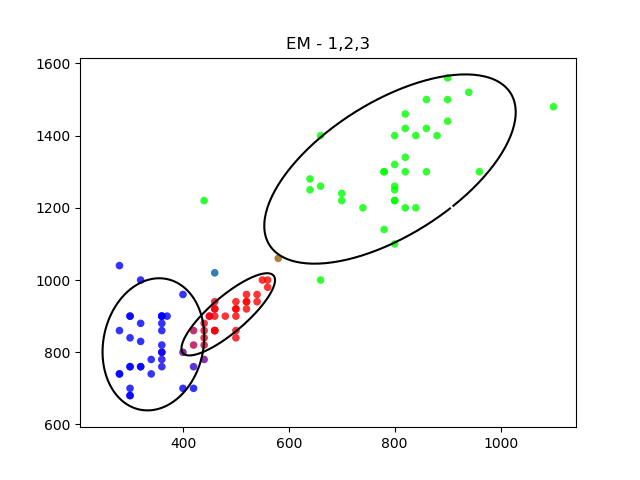

In [48]:
plot(clusters, parameters, "EM")